In [9]:
import higra as hg 
import numpy as np
from scipy.ndimage import maximum_filter, minimum_filter

In [10]:
def get_boundary(mask):
    m = mask.copy()
    m[m == 3] = 0 # this was added to handle presence only case in FTW
    field_mask = (m > 0).astype(np.uint8)

    local_max = maximum_filter(m, size=3)
    local_min = minimum_filter(m, size=3)
    boundary = ((local_max != local_min) & (field_mask > 0)).astype(np.float32)

    return boundary

In [11]:
def InstSegm(extent, boundary, t_ext=0.5, t_bound=0.2):
    """
    extent  : probability map [H, W] in [0,1] (foreground prob). 
    boundary: boundary map [H, W] in [0,1] (higher = stronger boundary)

    NOTE: While the expected input field extent should be a probability map, 
    this should work fine with ftw/lacuna because the function binarizes the 
    input (background vs fields_and_boundaries). 0: background, 1:field interior, 2: boundary.
    """

    extent = np.asarray(extent).squeeze().astype(np.float32)
    boundary = np.asarray(boundary).squeeze().astype(np.float32)

    if extent.shape != boundary.shape:
        raise ValueError(f"extent and boundary must have same shape. Got {extent.shape} vs {boundary.shape}")

    ext_binary = (extent >= t_ext).astype(np.uint8)
    input_hws = boundary.copy()
    input_hws[ext_binary == 0] = 1.0

    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(graph, input_hws, hg.WeightFunction.mean)
    tree, altitudes = hg.watershed_hierarchy_by_dynamics(graph, edge_weights)

    instances = hg.labelisation_horizontal_cut_from_threshold(
        tree, altitudes, threshold=t_bound
    ).astype(float)

    instances[ext_binary == 0] = np.nan # Mask out background

    return instances

In [40]:
import rasterio

def read_image(path):
    with rasterio.open(path) as src:
        img = src.read()  # (C, H, W)
        img = img.astype(np.float32) / 3000.0
    return img

def read_mask(path):
    with rasterio.open(path) as src:
        mask = src.read(1)
        mask = mask.astype(np.float32)
    return np.expand_dims(mask, axis=0)


In [33]:
import matplotlib.pyplot as plt

def show_sample(image_a, mask, boundary_mask, instance):
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    img_a = image_a
    img_a = np.moveaxis(img_a, 0, -1)  # (C,H,W) -> (H,W,C)
    img_a = np.clip(img_a, 0, 1)
    axes[0].imshow(img_a)
    axes[0].set_title('Win-A'); axes[0].axis('off')

    axes[1].imshow(mask, cmap="viridis", vmin=0, vmax=1)
    axes[1].set_title("GT Mask"); axes[1].axis('off')

    axes[2].imshow(boundary_mask, cmap="gray")
    axes[2].set_title('Boundary'); axes[2].axis('off')

    instance_np = instance
    im = axes[3].imshow(instance_np, cmap="prism", interpolation=None)
    axes[3].set_title('Instance Segmentation'); axes[3].axis('off')

    plt.tight_layout()
    plt.show()


## Example usage with random ftw samples

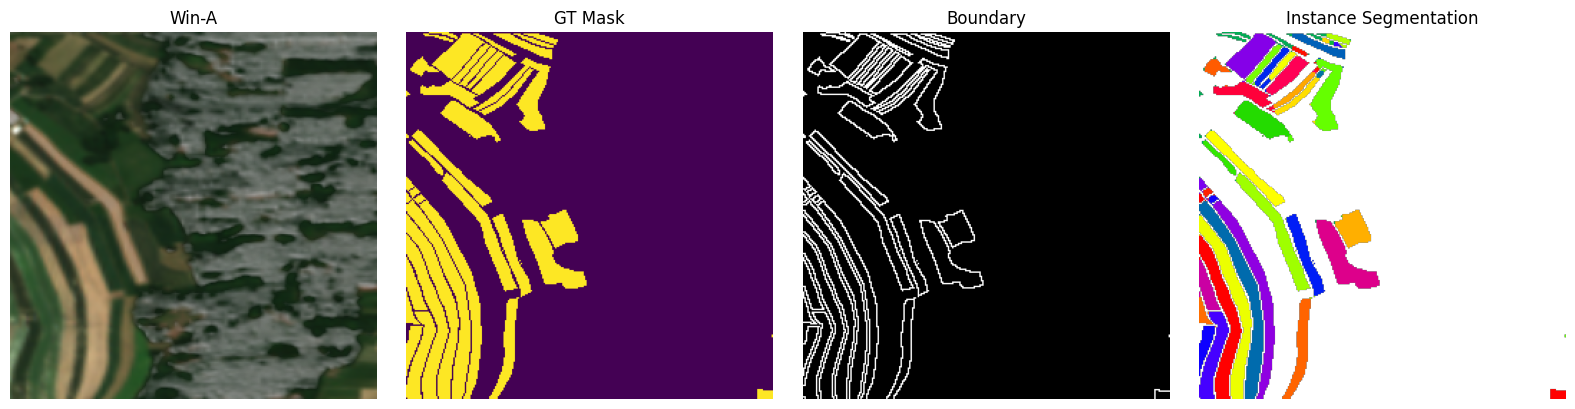

In [ ]:
ftw_dataset_root = "/u/gmuhawenayo/datasets/FTW-Dataset/ftw"
window_a_image_path = f"{ftw_dataset_root}/austria/s2_images/window_a/g94_00015_18.tif"
mask_path = f"{ftw_dataset_root}/austria/label_masks/semantic_2class/g94_00015_18.tif"

s2_image = read_image(window_a_image_path)
fields_mask = read_mask(mask_path)

boundary = get_boundary(fields_mask.squeeze())
instances = InstSegm(fields_mask, boundary, t_ext=0.5, t_bound=0.2)

show_sample(s2_image, fields_mask[0], boundary, instances)

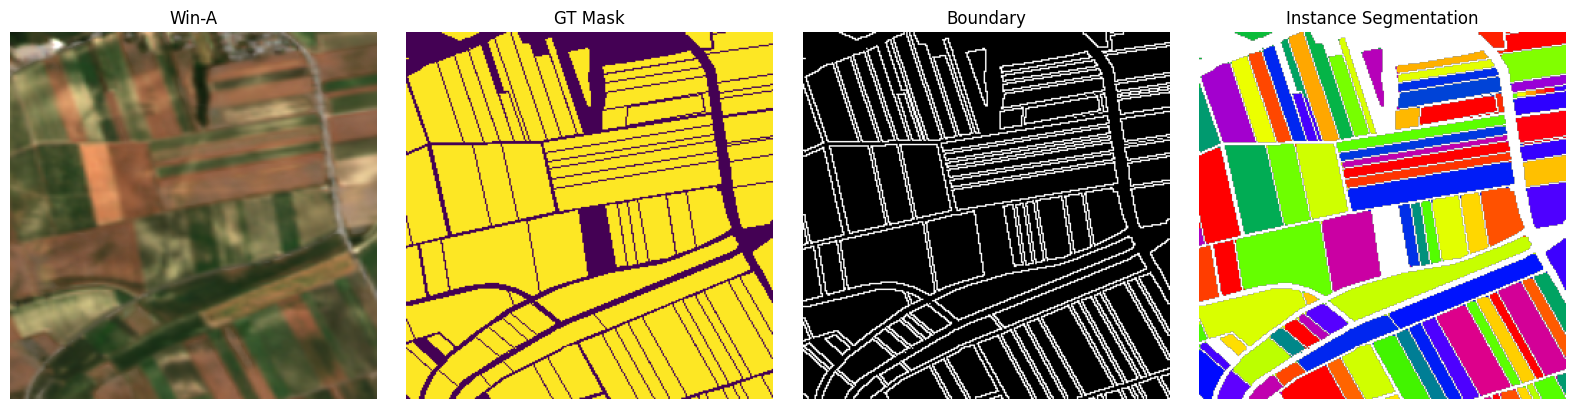

In [42]:
ftw_dataset_root = "/u/gmuhawenayo/datasets/FTW-Dataset/ftw"
window_a_image_path = f"{ftw_dataset_root}/austria/s2_images/window_a/g82_00029_0.tif"
mask_path = f"{ftw_dataset_root}/austria/label_masks/semantic_2class/g82_00029_0.tif"

s2_image = read_image(window_a_image_path)
fields_mask = read_mask(mask_path)

boundary = get_boundary(fields_mask.squeeze())
instances = InstSegm(fields_mask, boundary, t_ext=0.5, t_bound=0.2)

show_sample(s2_image, fields_mask[0], boundary, instances)

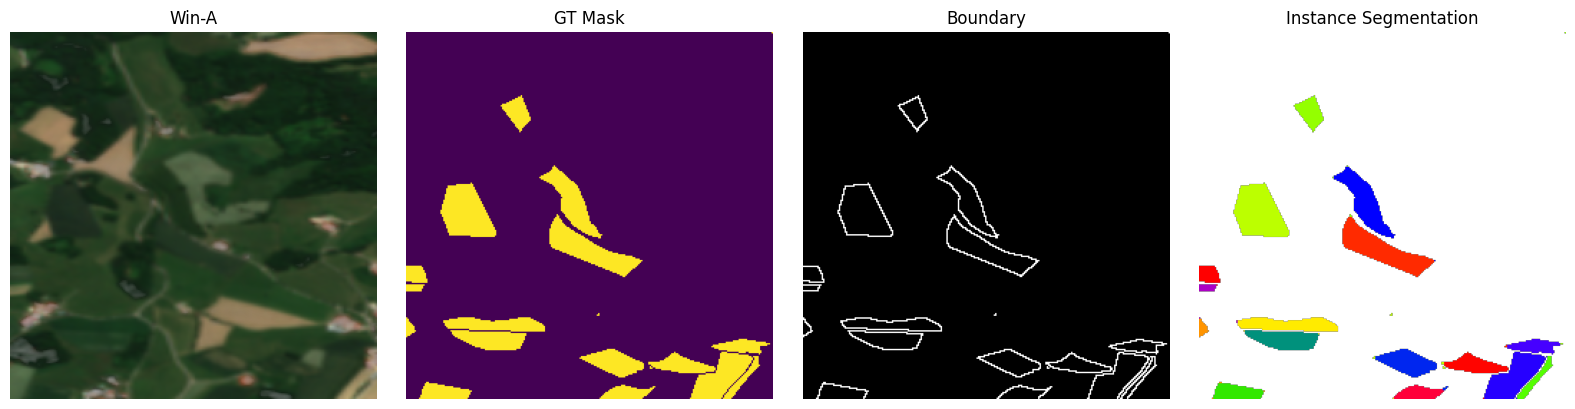

In [43]:
ftw_dataset_root = "/u/gmuhawenayo/datasets/FTW-Dataset/ftw"
window_a_image_path = f"{ftw_dataset_root}/austria/s2_images/window_a/g78_00041_0.tif"
mask_path = f"{ftw_dataset_root}/austria/label_masks/semantic_2class/g78_00041_0.tif"

s2_image = read_image(window_a_image_path)
fields_mask = read_mask(mask_path)

boundary = get_boundary(fields_mask.squeeze())
instances = InstSegm(fields_mask, boundary, t_ext=0.5, t_bound=0.2)

show_sample(s2_image, fields_mask[0], boundary, instances)

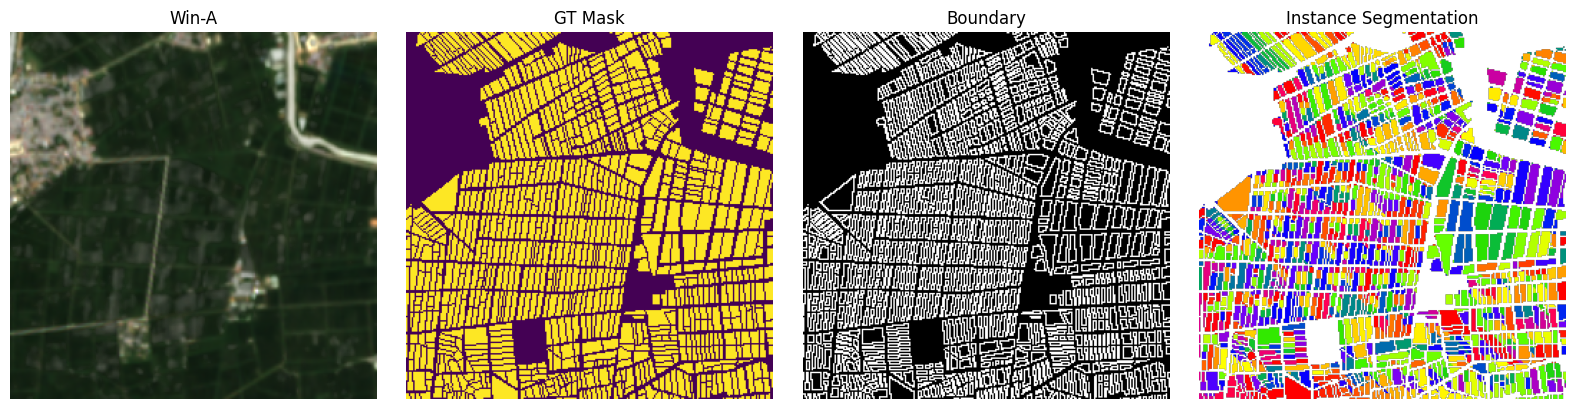

In [46]:
ftw_dataset_root = "/u/gmuhawenayo/datasets/FTW-Dataset/ftw"
window_a_image_path = f"{ftw_dataset_root}/vietnam/s2_images/window_a/g40_0000001024-0000001024.tif"
mask_path = f"{ftw_dataset_root}/vietnam/label_masks/semantic_2class/g40_0000001024-0000001024.tif"

s2_image = read_image(window_a_image_path)
fields_mask = read_mask(mask_path)

boundary = get_boundary(fields_mask.squeeze())
instances = InstSegm(fields_mask, boundary, t_ext=0.5, t_bound=0.2)

show_sample(s2_image, fields_mask[0], boundary, instances)

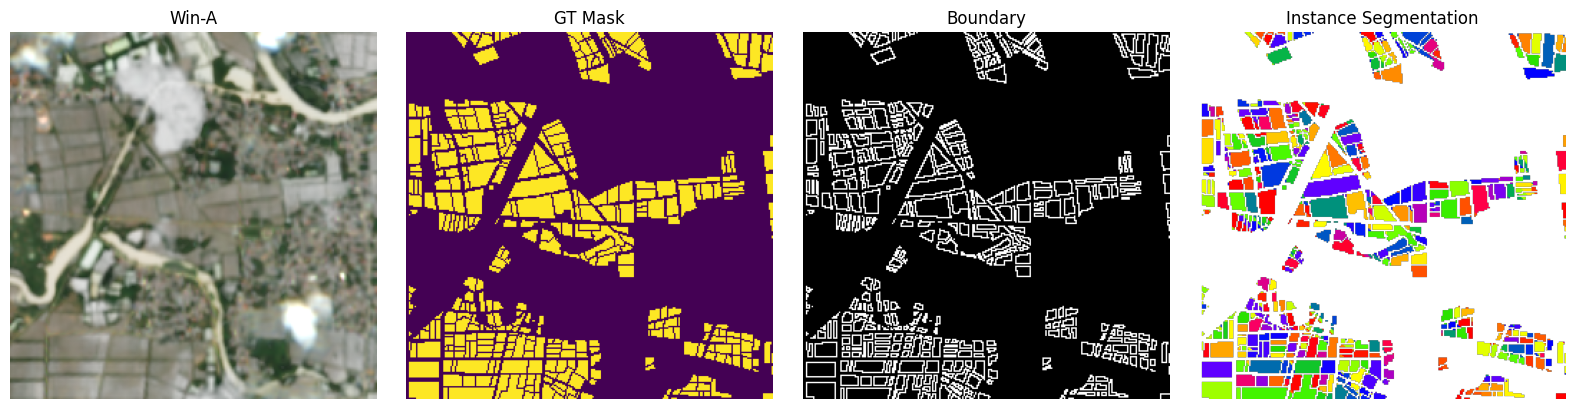

In [47]:
ftw_dataset_root = "/u/gmuhawenayo/datasets/FTW-Dataset/ftw"
window_a_image_path = f"{ftw_dataset_root}/vietnam/s2_images/window_a/g40_0000001024-0000000000.tif"
mask_path = f"{ftw_dataset_root}/vietnam/label_masks/semantic_2class/g40_0000001024-0000000000.tif"

s2_image = read_image(window_a_image_path)
fields_mask = read_mask(mask_path)

boundary = get_boundary(fields_mask.squeeze())
instances = InstSegm(fields_mask, boundary, t_ext=1, t_bound=0.2)

show_sample(s2_image, fields_mask[0], boundary, instances)